**1.** Import the relevant packages and dataset:

In [1]:
#import relevant packages
from keras.layers import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import pandas as pd

Using TensorFlow backend.


In [25]:
t=pd.read_csv('airline_sentiment.csv')
t.head()

,airline_sentiment,text
0,1,@VirginAmerica plus you've added commercials t...
1,0,@VirginAmerica it's really aggressive to blast...
2,0,@VirginAmerica and it's a really big bad thing...
3,0,@VirginAmerica seriously would pay $30 a fligh...
4,1,"@VirginAmerica yes, nearly every time I fly VX..."


In [26]:
t.columns

Index(['airline_sentiment', 'text'], dtype='object')

**2.** Preprocess the text to remove punctuation, normalize all words to lowercase, and remove the stopwords, as follows:

In [27]:
import nltk
nltk.download('stopwords')
stop = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gceran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
def preprocess(text):
    text=text.lower()
    text=re.sub('[^0-9a-zA-Z]+',' ',text)
    words = text.split()
    words2=[w for w in words if (w not in stop)]
    #words3=[ps.stem(w) for w in words]
    words4=' '.join(words2)
    return(words4)

In [29]:
t['text'] = t['text'].apply(preprocess)

In [30]:
t.head()

,airline_sentiment,text
0,1,virginamerica plus added commercials experienc...
1,0,virginamerica really aggressive blast obnoxiou...
2,0,virginamerica really big bad thing
3,0,virginamerica seriously would pay 30 flight se...
4,1,virginamerica yes nearly every time fly vx ear...


**3.** Extract the word-to-integer mapping of all the words that constitute the dataset:

In [31]:
from collections import Counter
counts = Counter()
for i,review in enumerate(t['text']):
    counts.update(review.split())

In the preceding step, we are extracting the frequency of all the words in the dataset. A sample of extracted words are as follows

In [32]:
words = sorted(counts, key=counts.get, reverse=True)
words[0:10]

['united',
 'flight',
 'usairways',
 'americanair',
 'southwestair',
 'jetblue',
 'get',
 'cancelled',
 'thanks',
 'service']

In [33]:
chars = words
nb_chars = len(words)
nb_chars

12532

In [34]:
word_to_int = {word: i for i, word in enumerate(words, 1)}
int_to_word = {i: word for i, word in enumerate(words, 1)}

In the preceding code, we are looping through all the words and are assigning an index for each word. A sample of integer to word dictionary is as follows:

In [35]:
list(int_to_word.items())[:10]

[(1, 'united'),
 (2, 'flight'),
 (3, 'usairways'),
 (4, 'americanair'),
 (5, 'southwestair'),
 (6, 'jetblue'),
 (7, 'get'),
 (8, 'cancelled'),
 (9, 'thanks'),
 (10, 'service')]

**4.** Map each word in a given sentence to the corresponding word associated with it

In [36]:
mapped_reviews = []
for review in t['text']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])

In [37]:
print('Original text:',t.loc[0]['text'])
print('Mapped text:',mapped_reviews[0])

Original text: virginamerica plus added commercials experience tacky
Mapped text: [44, 450, 1142, 2233, 100, 5429]


In [38]:
t.loc[0:1]['text']

0    virginamerica plus added commercials experienc...
1    virginamerica really aggressive blast obnoxiou...
Name: text, dtype: object

In [39]:
mapped_reviews[0:2]

[[44, 450, 1142, 2233, 100, 5429],
 [44, 57, 3036, 3845, 3846, 815, 3037, 3847, 19, 366, 2234]]

**5.** Extract the maximum length of a sentence and normalize all sentences to the same length by padding them. In the following code, we are looping through all the reviews and storing the length corresponding to each review. Additionally, we are also calculating the maximum length of a review (tweet text):

In [40]:
length_sent = []
for i in range(len(mapped_reviews)):
    length_sent.append(len(mapped_reviews[i]))
max(length_sent)

26

We should note that different tweets have different lengths. However, RNN expects the number of time steps for each input to be the same. In the code below, we are padding a mapped review  with a value of 0, if the length of the review is less than the maximum length of all reviews in dataset. This way, all inputs will have the same length.

In [41]:
sequence_length = max(length_sent)
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(maxlen=sequence_length, sequences=mapped_reviews, padding="post", value=0)

In [42]:
X.shape

(11541, 26)

**6.** Prepare the training and test datasets:

In [43]:
y=t['airline_sentiment'].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=10)
y_train2 = to_categorical(y_train)
y_test2 = to_categorical(y_test)

**7.** Build the RNN architecture and compile the model:

In [45]:
embedding_vecor_length=32
max_review_length=26
model = Sequential()
model.add(Embedding(input_dim=12533, output_dim=32, input_length = 26))

Note that embedding takes the total number of distinct words as input, and creates a vector for each word, where `output_dim` represents the number of dimensions in which the word is to be represented. `input_length` represents the number of words in each sentence.

In [46]:
model.add(SimpleRNN(40, return_sequences=False))

Note that, in the RNN layer, if we want to extract the output of each time step, we say the `return_sequences` parameter is `True`. However, in the use case that we are solving now, we extract the output only after reading through all the input words and thus `return_sequences = False`.

In [48]:
'''
modelex = Sequential()
modelex.add(Embedding(1000, 64, input_length=10))
# The model will take as input an integer matrix of size (batch,  
# input_length), and the largest integer (i.e. word index) in the input  
# should be no larger than 999 (vocabulary size).  
# Now model.output_shape is (None, 10, 64), where `None` is the batch  
# dimension.  
input_array = np.random.randint(1000, size=(32, 10))
'''

In [51]:
input_array.shape

(32, 10)

In [ ]:
'''
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array.shape)
'''

In [31]:
12533*32

401056

In [32]:
(32+40)*40+40

2920

In [35]:
12533*32+(32+40)*40+40+2*40+2 ##where is 40*40 coming from?

404058

In [52]:
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 32)            401056    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                2920      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 82        
Total params: 404,058
Trainable params: 404,058
Non-trainable params: 0
_________________________________________________________________
None


Let's understand why there are 401056 parameters to be estimated in the embedding layer. There are a total of 12,532 unique words, and if we consider that there is no word with an index of 0, it results in a total of 12,533 possible words where each is represented in 32 dimensions and hence (12,533 x 32 = 401,056) parameters to be estimated.

There is a set of weights that connect the input to the 40 units of RNN. Given that there are 32 inputs at each time step (where the same set of weights is repeated for each time step), a total of 32 x 40 weights is used to connect the input to the hidden layer. This gives an output that is of 1 x 40 in dimension for each input.

Additionally,if you consider the weights-connecting the previous time step's hidden layer to the current time step's hidden layer,we have 40 x 40 number of recurrent weights.

Along with weights, we would also have 40 bias terms associated with each of the 40 output and thus a total of (32 x 40 + 40 x 40 + 40 = 2,920) weights.

There are a total of 82 weights in the final layer, as the 40 units of the final time step are connected to the two possible output, resulting 40 x 2 weights and 2 biases, and thus a total of 82 units.

**8.** Fit the model:

In [53]:
history = model.fit(X_train, y_train2, validation_data=(X_test, y_test2), epochs=10, batch_size=32)

/Users/gceran/opt/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8078 samples, validate on 3463 samples
Epoch 1/10
8078/8078 [==============================] - 12s 2ms/step - loss: 0.3281 - accuracy: 0.8706 - val_loss: 0.2477 - val_accuracy: 0.9047
Epoch 2/10
8078/8078 [==============================] - 10s 1ms/step - loss: 0.1307 - accuracy: 0.9562 - val_loss: 0.3025 - val_accuracy: 0.8963
Epoch 3/10
8078/8078 [==============================] - 11s 1ms/step - loss: 0.0552 - accuracy: 0.9830 - val_loss: 0.3356 - val_accuracy: 0.9001
Epoch 4/10
8078/8078 [==============================] - 10s 1ms/step - loss: 0.0303 - accuracy: 0.9910 - val_loss: 0.3368 - val_accuracy: 0.9001
Epoch 5/10
8078/8078 [==============================] - 10s 1ms/step - loss: 0.0132 - accuracy: 0.9963 - val_loss: 0.3969 - val_accuracy: 0.8972
Epoch 6/10
8078/8078 [==============================] - 10s 1ms/step - loss: 0.0111 - accuracy: 0.9970 - val_loss: 0.4465 - val_accuracy: 0.8880
Epoch 7/10
8078/8078 [==============================] - 10s 1ms/step - loss: 0.009

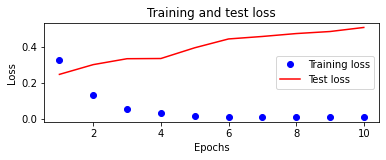

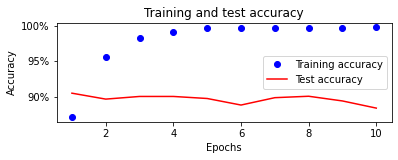

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.ticker as mtick
plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()
plt.subplot(212)
plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid(False)
plt.show()